In [ ]:
!pip install albumentations==1.2.1
!pip install timm
!pip install openvino
import timm
import os
import zipfile
import pathlib
import sklearn
import torchvision
import random
import torch
import torch.nn.functional as F
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as tt
from torchvision.utils import make_grid
from tqdm import tqdm
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from types import SimpleNamespace
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import cv2
from tqdm import tqdm
import gc
from google.colab.patches import cv2_imshow
from torch.utils.tensorboard import SummaryWriter
from torch.optim.swa_utils import AveragedModel, SWALR
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

os.environ['PYTHONHASHSEED'] = str(27)
random.seed(27)
np.random.seed(27)
torch.manual_seed(27)
torch.cuda.manual_seed(27)
torch.cuda.manual_seed_all(27)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 27.4 MB/s 
     |████████████████████████████████| 163 kB 68.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.8 MB 15.0 MB/s 
Mounted at /content/drive


In [ ]:
def seed_everything(seed=27):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
zipFile = zipfile.ZipFile('/content/drive/MyDrive/Datasets/Caltech256.zip', 'r')
zipFile.extractall('Caltech256')
zipFile.close()
zipFile = zipfile.ZipFile("/content/drive/MyDrive/Datasets/Caltech256_lists.zip", 'r')
zipFile.extractall('Caltech256_lists')
zipFile.close()

#New dataset setup

In [ ]:
seed_everything()
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
mean = [0.5520, 0.5336, 0.5051]
std = [0.2379, 0.2371, 0.2397]
train_transforms1 = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            
            A.HorizontalFlip(p=0.9),
            A.VerticalFlip(p=0.9),
            A.InvertImg(p=0.7),
            A.Normalize(
                mean=mean,
                std=std,
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

train_transforms2 = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            # A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25),
            # A.Blur(blur_limit=5, p=0.7),
            # A.RandomBrightnessContrast(p=0.5),
            # A.ChannelShuffle(p=0.7),
            # A.Solarize(threshold=128, p=0.5),
            
            # A.InvertImg(p=0.7),
            A.Normalize(
                mean=mean,
                std=std,
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

train_transforms3 = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25),
            A.Blur(blur_limit=5, p=0.7),
            A.RandomBrightnessContrast(p=0.5),
            # A.Solarize(threshold=128, p=0.5),
            # A.GaussNoise(),
            # A.InvertImg(p=0.7),
            A.Solarize(threshold=128, p=0.5),
            A.Normalize(
                mean=mean,
                std=std,
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

train_transforms4 = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.GaussNoise(),
            A.Rotate(limit=35, p=1.0),
            A.ChannelShuffle(p=0.7),
            A.Normalize(
                mean=mean,
                std=std,
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )
val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=mean,
                std=std,
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [ ]:
class Caltech256Dataset(Dataset):
  def __init__(self, list_path, transform=None, image_dir="/content/Caltech256/"):
    self.file_path = list_path
    self.image_dir = image_dir
    self.transforms = transform
    self.file = open(self.file_path, encoding='utf-8')
    self.text = self.file.read()
    self.image_descriptions = self.text.split("\n")
    

  def __getitem__(self, index):
    image_discription = self.image_descriptions[index].split()
    img_path = "/content/Caltech256/" +  image_discription[0]
    label = int(image_discription[1])
    image = np.array(Image.open(img_path).convert("RGB"))
    if self.transforms is not None:
      augmentations = self.transforms(image=image)
      image = augmentations["image"]
    return image, label

  
  def __len__(self):
    return len(self.image_descriptions)-1

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
      return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
      self.dl = dl
      self.device = device
      
  def __iter__(self):
      """Yield a batch of data after moving it to device"""
      for b in self.dl: 
          yield to_device(b, self.device)

  def __len__(self):
      """Number of batches"""
      return len(self.dl)

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
NUM_WORKERS = 2
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256 
PIN_MEMORY = True
TRAIN_LIST_PATH = "/content/Caltech256_lists/Caltech256_lists/train_lst.txt"
VAL_LIST_PATH = "/content/Caltech256_lists/Caltech256_lists/val_lst.txt"
TEST_LIST_PATH = "/content/Caltech256_lists/Caltech256_lists/test_lst.txt"

In [ ]:
seed_everything()
train_dataset1 = Caltech256Dataset(
        list_path=TRAIN_LIST_PATH,
        transform=val_transforms,
    )
train_dataset2 = Caltech256Dataset(
        list_path=TRAIN_LIST_PATH,
        transform=train_transforms2,
    )
train_dataset3 = Caltech256Dataset(
        list_path=TRAIN_LIST_PATH,
        transform=train_transforms3,
    )

train_dataset4 = Caltech256Dataset(
        list_path=TRAIN_LIST_PATH,
        transform=train_transforms4,
    )

train_dataset = torch.utils.data.ConcatDataset([train_dataset1, train_dataset2, train_dataset3, train_dataset4])

val_dataset = Caltech256Dataset(
        list_path=VAL_LIST_PATH,
        transform=val_transforms,
    )
test_dataset = Caltech256Dataset(
        list_path=TEST_LIST_PATH,
        transform=val_transforms,
    )

train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
    )

val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
    )

test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
    )

# train_loader = DeviceDataLoader(train_loader, DEVICE)
# val_loader = DeviceDataLoader(val_loader, DEVICE)
# test_loader = DeviceDataLoader(test_loader, DEVICE)

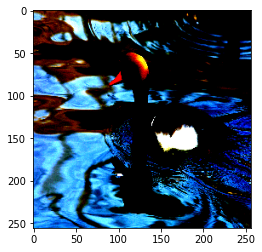

In [ ]:
image, _ = train_dataset[55]
plt.imshow(image.permute(1, 2, 0).clamp(0, 1))

#Assets

In [ ]:
def get_mean_and_std(data_loader):
  mean = 0
  std = 0
  images_count = 0
  for images, _ in data_loader:
    
    images_in_the_batch = images.size(0)
    images = images.view(images_in_the_batch, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    images_count += images_in_the_batch
  
  mean /= images_count
  std /= images_count
  
  return mean, std

def check_accuracy(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    print("accuracy = ", num_correct/num_samples)
    return num_correct/num_samples


In [ ]:
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def train_with_distillation(train_loader, test_loader, model, loss_fn, optimizer, teacher_model, max_lr, epochs, alpha = 0.7, temperature = 3):
    # alpha = 0.4
    # temperature = 3
    seed_everything()
    # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
    #                                            steps_per_epoch=len(train_loader))
    
    writer = SummaryWriter("/content/boards/board")
    step = 0
    images, _ = next(iter(train_loader))
    grid = make_grid(images)
    writer.add_image('images', grid)

    # sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.5)
    teacher_model.eval()
    for epoch in range(epochs):
      model.train()
      total_loss = 0
      len_losses = 0
      loop = tqdm(train_loader, leave=True)
      for batch_idx, (data, targets) in enumerate(loop):
          data = data.to(DEVICE)
          targets = targets.to(DEVICE)

          scores = model(data)
          teacher_model_scores = teacher_model(data)
          teacher_prob = F.softmax(teacher_model_scores/temperature, dim=1)
          student_prob = F.softmax(scores/temperature, dim=1)
          loss = alpha * loss_fn(scores, targets) + (1 - alpha) * F.kl_div(student_prob, teacher_prob)

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          len_losses += 1
          total_loss += loss.item()
          loop.set_postfix(loss=loss.item())
          # sched.step()
      # sched.step()
      mean_loss = total_loss / len_losses
      writer.add_scalar("Total training loss", total_loss, global_step=step)
      writer.add_scalar("Mean loss loss", mean_loss, global_step=step)

      accuracy = check_accuracy(test_loader, model, DEVICE)
      if accuracy>0.6:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/Models/Caltech256_distill_resnet18_val_acc={accuracy}")
      writer.add_scalar("Training Accuracy", accuracy, global_step=step)
      step += 1
    writer.close()

def swa_train(train_loader, test_loader, model, loss_fn, optimizer, max_lr, epochs, swa_scheduler, swa_model, swa_start):
    seed_everything()
    sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma=0.5)
    # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
    #                                            steps_per_epoch=len(train_loader), cycle_momentum=False)
    step = 0
    writer = SummaryWriter()
    images, _ = next(iter(train_loader))
    grid = make_grid(images)
    writer.add_image('images', grid)
    for epoch in range(epochs):
      model.train()
      total_loss = 0
      loop = tqdm(train_loader, leave=True)
      len_losses = 0
      for batch_idx, (data, targets) in enumerate(loop):
          data = data.to(DEVICE)
          targets = targets.to(DEVICE)

          scores = model(data)
          loss = loss_fn(scores, targets)
          total_loss += loss.item()
          len_losses += 1

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          loop.set_postfix(loss=loss.item())
          if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
          # else:
          #   sched.step()
      sched.step()
      mean_loss = total_loss / len_losses

      writer.add_scalar("Total training loss", total_loss, global_step=step)
      writer.add_scalar("Mean loss loss", total_loss, global_step=step)

 
      accuracy = check_accuracy(test_loader, model, DEVICE) 
      if accuracy > 0.62:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/Models/Caltech256_resnet18_val_acc={accuracy}")
      writer.add_scalar("Training Accuracy", accuracy, global_step=step)
      step +=1
    writer.close()
    torch.optim.swa_utils.update_bn(train_loader, swa_model)
    check_accuracy(test_loader, swa_model, DEVICE)

def simple_train(train_loader, test_loader, model, loss_fn, optimizer, max_lr, epochs):
    seed_everything()
    # sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.1)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                               steps_per_epoch=len(train_loader), cycle_momentum=False)
    step = 0
    writer = SummaryWriter()
    images, _ = next(iter(train_loader))
    grid = make_grid(images)
    writer.add_image('images', grid)
    for epoch in range(epochs):
      model.train()
      total_loss = 0
      loop = tqdm(train_loader, leave=True)
      len_losses = 0
      for batch_idx, (data, targets) in enumerate(loop):
          data = data.to(DEVICE)
          targets = targets.to(DEVICE)

          scores = model(data)
          loss = loss_fn(scores, targets)
          total_loss += loss.item()
          len_losses += 1

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          loop.set_postfix(loss=loss.item())
          sched.step()
      # sched.step()
      mean_loss = total_loss / len_losses

      writer.add_scalar("Total training loss", total_loss, global_step=step)
      writer.add_scalar("Mean loss loss", total_loss, global_step=step)

      accuracy = check_accuracy(test_loader, model, DEVICE)
      if accuracy > 0.61:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/Models/Caltech256_resnet18_val_acc={accuracy}")
      writer.add_scalar("Training Accuracy", accuracy, global_step=step)
      step +=1
    writer.close()


def train_one_epoch(loader, model, loss_fn, optimizer):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)

        scores = model(data)
        loss = loss_fn(scores, targets)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loop.set_postfix(loss=loss.item())

In [ ]:
# weights = [0]*256
# print(len(train_dataset1))
# length = len(train_dataset1)
# for i in range(len(train_dataset1)):
#   _, label = train_dataset1[i]
#   weights[label] += 1

# print(weights)
# weights = [59, 91, 77, 90, 54, 64, 140, 62, 58, 168, 130, 60, 52, 74, 55, 64, 61, 76, 51, 86, 59, 66, 68, 70, 64, 60, 66, 63, 64, 54, 61, 62, 60, 53, 64, 72, 66, 51, 76, 53, 53, 76, 73, 51, 81, 58, 63, 64, 59, 70, 51, 50, 72, 60, 62, 64, 57, 51, 53, 62, 51, 74, 79, 61, 51, 51, 66, 61, 52, 61, 72, 60, 69, 51, 52, 56, 54, 61, 70, 57, 49, 57, 52, 68, 48, 57, 60, 66, 128, 57, 121, 68, 64, 52, 171, 55, 60, 48, 57, 84, 54, 67, 59, 162, 53, 55, 51, 94, 51, 52, 52, 70, 72, 54, 65, 73, 66, 53, 78, 50, 63, 67, 55, 61, 146, 78, 63, 114, 55, 56, 114, 82, 73, 57, 57, 94, 116, 52, 55, 71, 65, 78, 50, 480, 50, 122, 106, 63, 67, 67, 72, 57, 63, 56, 58, 63, 91, 127, 51, 63, 55, 54, 61, 54, 56, 52, 84, 56, 62, 52, 61, 64, 52, 51, 66, 58, 60, 48, 62, 60, 72, 60, 52, 63, 49, 57, 54, 73, 68, 67, 68, 106, 68, 53, 64, 60, 66, 63, 60, 49, 59, 55, 48, 53, 60, 69, 67, 62, 67, 57, 82, 61, 85, 52, 60, 63, 49, 52, 58, 63, 55, 48, 66, 54, 61, 89, 57, 57, 58, 68, 216, 60, 74, 70, 59, 54, 59, 52, 121, 57, 57, 54, 55, 55, 61, 56, 52, 60, 58, 480, 70, 261, 57, 63, 66, 60]
# length = len(train_dataset1)
# for i in range(len(weights)):
#   weights[i] = length/(weights[i]*256)

# print(weights)
# print("hello")



#Model setup

In [ ]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model = timm.create_model('resnet18', pretrained=False, num_classes=256)
# model.load_state_dict(torch.load("/content/drive/MyDrive/Models/Caltech256_distill_resnet18_val_acc=0.5963834524154663"))
# swa_model = AveragedModel(model)
# teacher_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
# teacher_model.classifier = nn.Linear(1024, 256)
# teacher_model.load_state_dict(torch.load("/content/drive/MyDrive/Models/Caltech256_teacher_densenet121_val_acc=0.8039917945861816"))

# for param in teacher_model.parameters():
#     param.requires_grad = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# teacher_model = teacher_model.to(DEVICE)
# weights = [1.1755208333333333, 1.1954449152542372, 0.7750686813186813, 0.9159902597402597, 0.7836805555555556, 1.3061342592592593, 1.10205078125, 0.5037946428571428, 1.137600806451613, 1.2160560344827587, 0.41982886904761907, 0.5425480769230769, 1.1755208333333333, 1.3563701923076923, 0.953125, 1.2823863636363637, 1.10205078125, 1.15625, 0.9280427631578947, 1.3829656862745099, 0.8201308139534884, 1.1954449152542372, 1.068655303030303, 1.0372242647058822, 1.0075892857142856, 1.10205078125, 1.1755208333333333, 1.068655303030303, 1.1195436507936507, 1.10205078125, 1.3061342592592593, 1.15625, 1.137600806451613, 1.1755208333333333, 1.3307783018867925, 1.10205078125, 0.9796006944444444, 1.068655303030303, 1.3829656862745099, 0.9280427631578947, 1.3307783018867925, 1.3307783018867925, 0.9280427631578947, 0.966181506849315, 1.3829656862745099, 0.8707561728395061, 1.2160560344827587, 1.1195436507936507, 1.10205078125, 1.1954449152542372, 1.0075892857142856, 1.3829656862745099, 1.410625, 0.9796006944444444, 1.1755208333333333, 1.137600806451613, 1.10205078125, 1.237390350877193, 1.3829656862745099, 1.3307783018867925, 1.137600806451613, 1.3829656862745099, 0.953125, 0.8928006329113924, 1.15625, 1.3829656862745099, 1.3829656862745099, 1.068655303030303, 1.15625, 1.3563701923076923, 1.15625, 0.9796006944444444, 1.1755208333333333, 1.0221920289855073, 1.3829656862745099, 1.3563701923076923, 1.2594866071428572, 1.3061342592592593, 1.15625, 1.0075892857142856, 1.237390350877193, 1.4394132653061225, 1.237390350877193, 1.3563701923076923, 1.0372242647058822, 1.4694010416666667, 1.237390350877193, 1.1755208333333333, 1.068655303030303, 0.551025390625, 1.237390350877193, 0.5829028925619835, 1.0372242647058822, 1.10205078125, 1.3563701923076923, 0.41246345029239767, 1.2823863636363637, 1.1755208333333333, 1.4694010416666667, 1.237390350877193, 0.8396577380952381, 1.3061342592592593, 1.052705223880597, 1.1954449152542372, 0.43537808641975306, 1.3307783018867925, 1.2823863636363637, 1.3829656862745099, 0.7503324468085106, 1.3829656862745099, 1.3563701923076923, 1.3563701923076923, 1.0075892857142856, 0.9796006944444444, 1.3061342592592593, 1.0850961538461539, 0.966181506849315, 1.068655303030303, 1.3307783018867925, 0.9042467948717948, 1.410625, 1.1195436507936507, 1.052705223880597, 1.2823863636363637, 1.15625, 0.4830907534246575, 0.9042467948717948, 1.1195436507936507, 0.6186951754385965, 1.2823863636363637, 1.2594866071428572, 0.6186951754385965, 0.8601371951219512, 0.966181506849315, 1.237390350877193, 1.237390350877193, 0.7503324468085106, 0.6080280172413793, 1.3563701923076923, 1.2823863636363637, 0.9933978873239436, 1.0850961538461539, 0.9042467948717948, 1.410625, 0.14694010416666667, 1.410625, 0.578125, 0.6653891509433962, 1.1195436507936507, 1.052705223880597, 1.052705223880597, 0.9796006944444444, 1.237390350877193, 1.1195436507936507, 1.2594866071428572, 1.2160560344827587, 1.1195436507936507, 0.7750686813186813, 0.5553641732283464, 1.3829656862745099, 1.1195436507936507, 1.2823863636363637, 1.3061342592592593, 1.15625, 1.3061342592592593, 1.2594866071428572, 1.3563701923076923, 0.8396577380952381, 1.2594866071428572, 1.137600806451613, 1.3563701923076923, 1.15625, 1.10205078125, 1.3563701923076923, 1.3829656862745099, 1.068655303030303, 1.2160560344827587, 1.1755208333333333, 1.4694010416666667, 1.137600806451613, 1.1755208333333333, 0.9796006944444444, 1.1755208333333333, 1.3563701923076923, 1.1195436507936507, 1.4394132653061225, 1.237390350877193, 1.3061342592592593, 0.966181506849315, 1.0372242647058822, 1.052705223880597, 1.0372242647058822, 0.6653891509433962, 1.0372242647058822, 1.3307783018867925, 1.10205078125, 1.1755208333333333, 1.068655303030303, 1.1195436507936507, 1.1755208333333333, 1.4394132653061225, 1.1954449152542372, 1.2823863636363637, 1.4694010416666667, 1.3307783018867925, 1.1755208333333333, 1.0221920289855073, 1.052705223880597, 1.137600806451613, 1.052705223880597, 1.237390350877193, 0.8601371951219512, 1.15625, 0.8297794117647059, 1.3563701923076923, 1.1755208333333333, 1.1195436507936507, 1.4394132653061225, 1.3563701923076923, 1.2160560344827587, 1.1195436507936507, 1.2823863636363637, 1.4694010416666667, 1.068655303030303, 1.3061342592592593, 1.15625, 0.7924859550561798, 1.237390350877193, 1.237390350877193, 1.2160560344827587, 1.0372242647058822, 0.3265335648148148, 1.1755208333333333, 0.953125, 1.0075892857142856, 1.1954449152542372, 1.3061342592592593, 1.1954449152542372, 1.3563701923076923, 0.5829028925619835, 1.237390350877193, 1.237390350877193, 1.3061342592592593, 1.2823863636363637, 1.2823863636363637, 1.15625, 1.2594866071428572, 1.3563701923076923, 1.1755208333333333, 1.2160560344827587, 0.14694010416666667, 1.0075892857142856, 0.27023467432950193, 1.237390350877193, 1.1195436507936507, 1.068655303030303]
# weights = torch.tensor(weights, device=DEVICE)
model = model.to(DEVICE)
# swa_model = swa_model.to(DEVICE)

WEIGHT_DECAY = 1e-4
LEARNING_RATE = 1e-03
NUM_EPOCHS = 30
# SWA_START = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
# swa_scheduler = SWALR(optimizer, swa_lr=5.08e-05)
# lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")
# lr_finder.range_test(train_loader, end_lr=1, num_iter=200)
# lr_finder.plot()

#Train

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
seed_everything()
simple_train(train_loader, val_loader, model, loss_fn, optimizer, LEARNING_RATE, NUM_EPOCHS)
# swa_train(train_loader, val_loader, model, loss_fn, optimizer, LEARNING_RATE, NUM_EPOCHS, swa_scheduler, swa_model, SWA_START)
# train_with_distillation(train_loader, val_loader, model, loss_fn, optimizer, teacher_model,
#                         LEARNING_RATE, NUM_EPOCHS, alpha = 0.8, temperature = 2)

In [ ]:
model.eval()
check_accuracy(test_loader, model, DEVICE)

accuracy =  tensor(0.6087, device='cuda:0')


tensor(0.6087, device='cuda:0')

In [ ]:
torch.save(swa_model.state_dict(), "/content/drive/MyDrive/Models/Caltech256_swa_resnet18_val_acc=0,6216_test_acc=0,6087")

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/Boards/resnet18_caltech256

#Onnx and Openvino part

In [ ]:
import openvino
from openvino.inference_engine import IENetwork
from openvino.inference_engine import IECore
from openvino.runtime import Core


In [ ]:
# model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=False)
# model.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
#                                         nn.Flatten(),
#                                         nn.Dropout(p = 0.2),
#                                         nn.Linear(1280, 257)
#                                         )
model = timm.create_model('resnet18', pretrained=False, num_classes=256)
model.load_state_dict(torch.load("/content/drive/MyDrive/Models/Caltech256_resnet18_val_acc=0.6241896748542786", map_location=torch.device('cpu')))


batch = torch.randn(1, 3, 256, 256)
model.eval()
torch.onnx.export(model, batch, "Caltech256_resnet18.onnx", export_params=True, opset_version=11)


ie = Core()
onnx_model = ie.read_model(model="Caltech256_resnet18.onnx")
compiled_onnx_model = ie.compile_model(model=onnx_model, device_name="CPU")
input_layer = compiled_onnx_model.input(0)
output_layer = compiled_onnx_model.output(0)


num_correct = 0
num_samples = 0
for i in range(len(val_dataset)):
  img, y = val_dataset[i]

  
  img = img.unsqueeze(0)
  preds = compiled_onnx_model([img])[output_layer]
  preds = torch.from_numpy(preds)
  preds = torch.softmax(preds, 1)

  _, predictions = preds.max(1)
  num_correct += (predictions == y).sum()
  num_samples += predictions.size(0)
print ("accuracy = ", num_correct/num_samples)

accuracy =  tensor(0.6242)
